# Google Trends insight in understanding what drives Norwegians into purchasing an electric vehicle
Authors: 
- 270226 - Max Chevron 
- 321733 - Shasha Jiang 
- 314205 - Jostein Leirgulen 

Date: 03.12.2020 

In [1]:
import pickle
import pandas as pd 
from dateutil import relativedelta as rdelta
from datetime import datetime, date
import time
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats import diagnostic
import statsmodels.formula.api as smf
from pytrends.request import TrendReq
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.regression.linear_model as lm
from sklearn.metrics import mean_absolute_error

## Load Dataframes

In [ ]:
df_inter = pd.read_pickle('pytrends.pickle')
df_sales = pd.read_pickle('sales.pickle')

## AR using Statsmodels

In [18]:
'''
Function Goal: Plot either baseline or model with keywords
Function input: sales - df with "ev_sales" as a column
                trends - df containing all google trends data
                keywords - list specifying which trends to use
                n_test - number of weeks that will be used for training
Function output: List of predicted sales using the fitted model

HOW TO PLOT BASELINE: Just pass sales (or market share), nothing else
HOW TO PLOT IMPROVED: Pass sales, trends and keywords
'''

def pred_sales_AR(sales_df, trends=None, keywords=[], n_test=17*4, disp=True):
    
    ## Instantiate models - create baseline if no trends dataframe is passed
    if trends is None:
        AR_model = AutoReg(sales_df["ev_share"],
                           lags=[1, 52],
                           hold_back = n_test,
                           old_names=False)
    else:
        AR_model = AutoReg(sales_df["ev_share"],
                           lags=[1, 52],
                           hold_back = n_test,
                           exog=trends[keywords],
                           old_names=False)
    
    ## Fit model
    AR_fit = AR_model.fit()
    
    ## Predict values using model
    pred_sales = AR_fit.predict(start=n_test) 

    ## Print summary
    if(disp):
        display(AR_fit.summary())
    
    return pred_sales, AR_fit.aic

In [19]:
def calc_MAE(sales_df, baseline, improved, n_test=17*4):
    
    ## Slice out test set
    df_sales_test = sales_df.iloc[n_test:,:]
    
    ## Calculate totall MAE
    baseline_MAE = mean_absolute_error(df_sales_test["ev_share"], baseline)
    improved_MAE = mean_absolute_error(df_sales_test["ev_share"], improved)
    
    ## Calculate overall improvement and return it
    return ((baseline_MAE-improved_MAE)/baseline_MAE)*100

In [21]:
'''
Function goal: Plot models over empirical data
'''

def plot_AR(sales, baseline, improved, zoom_year=False):
    
    ## Create figure
    fig, ax = plt.subplots()
    
    ## Plot empirical
    sales["ev_share"].plot(figsize=(15,5))
    
    ## Iteratively plot predicted
    baseline.plot(figsize=(15,5))
    improved.plot(figsize=(15,5))

    ### Add legend
    plt.legend((['Actual', 'Base', 'Improved']))

    ### Add axis label and header
    ax.set_ylabel('Market Share')
    ax.set_xlabel('Date')
    ax.set_title('Market share of EV-vehicles in Norway')
    
    if(zoom_year):
        ax.set_xlim([date(2018, 1, 1), date(2019,1,1)])

In [150]:
pred_sales_baseline, _ = pred_sales_AR(df_sales, disp=False)
pred_sales_improved, _ = pred_sales_AR(df_sales, df_inter, 
                                       keywords=["Elbil avgift", "Elbil parkering", "Elbil pris", "Tesla", "Nissan Leaf"], 
                                       disp=False)

C:\Users\Jostein\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


In [151]:
MAE_improvement = calc_MAE(df_sales, pred_sales_baseline, pred_sales_improved)
MAE_improvement

3.67894565807479

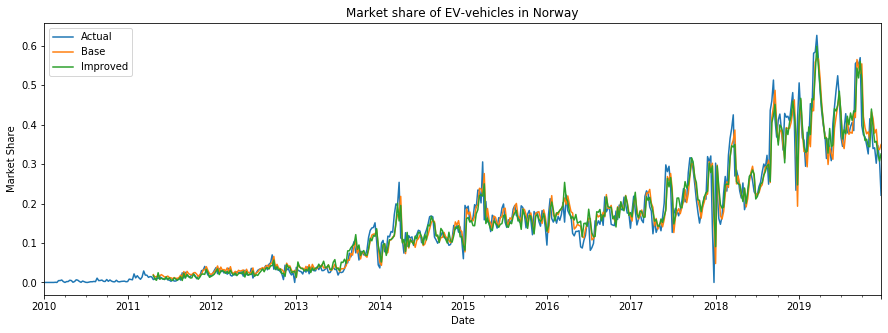

In [152]:
plot_AR(df_sales, pred_sales_baseline, pred_sales_improved)

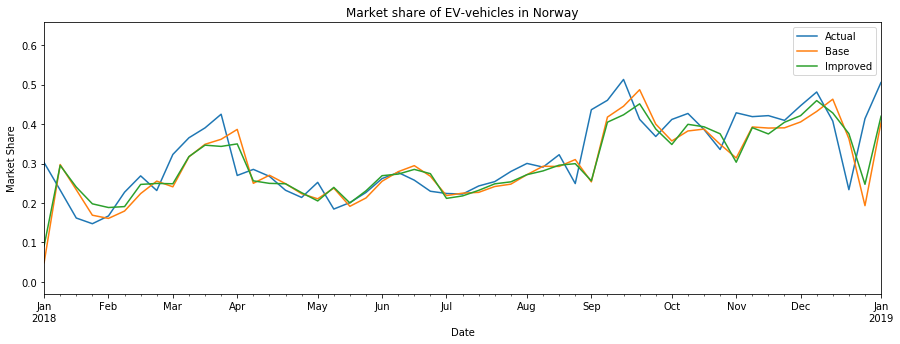

In [153]:
plot_AR(df_sales, pred_sales_baseline, pred_sales_improved, zoom_year=True)

In [78]:
pred_sales_baseline, _ = pred_sales_AR(df_sales, disp=False)
AIC_improvement = []
MAE_improvement = []
AIC_keyword = []

all_keywords = df_inter.columns.to_list()
for kw in all_keywords:
    AIC_keyword.append(kw)
    
    pred_MarketShare, AIC = pred_sales_AR(df_sales, df_inter, keywords=kw, disp=False)
    MAE = calc_MAE(df_sales, pred_sales_baseline, pred_MarketShare)
    
    MAE_improvement.append(MAE)
    AIC_improvement.append(AIC)

C:\Users\Jostein\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


In [79]:
AIC_keyword_df = pd.DataFrame(AIC_keyword, columns=['Keywords'])
AIC_improvement_df = pd.DataFrame(AIC_improvement, columns=['AIC'])
MAE_improvement = pd.DataFrame(MAE_improvement, columns=['MAE'])
AIC_df = pd.concat([AIC_keyword_df, AIC_improvement_df, MAE_improvement], join='outer', axis=1)
AIC_df = AIC_df.sort_values(by='AIC', ascending=False)

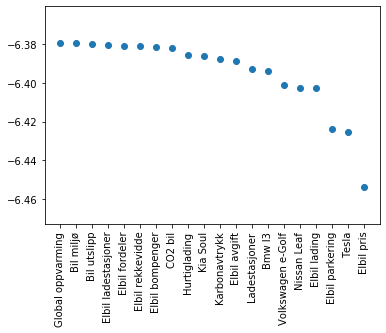

In [80]:
fig, ax = plt.subplots(1,1) 
plt.scatter(np.linspace(1, 20, 20), AIC_df["AIC"])
ax.set_xticks(np.linspace(1, 20, 20))
ax.set_xticklabels(AIC_df["Keywords"], rotation='vertical');

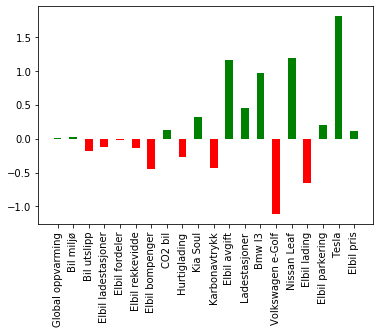

In [81]:
fig, ax = plt.subplots(1,1) 
#ind = np.arange(AIC_df.shape[0])
colormat=np.where(AIC_df['MAE']>0, 'g','r')
ax.bar(ind, AIC_df['MAE'], width=0.5, color=colormat)
ax.set_xticks(np.linspace(0, 19, 20))
ax.set_xticklabels(AIC_df["Keywords"], rotation='vertical');

### Shared y axis

Text(0.5, 1.0, 'MAE')

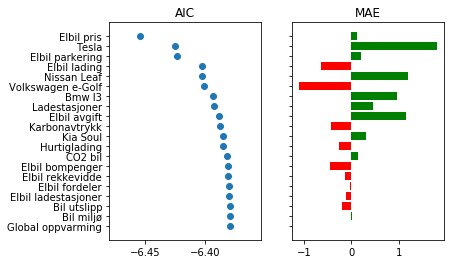

In [133]:
y = np.linspace(1, 20, 20)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(AIC_df["AIC"], y)
ax1.set_yticks(y)
ax1.set_yticklabels(AIC_df["Keywords"]);
ax1.set_title('AIC')

colormat=np.where(AIC_df['MAE']>0, 'g','r')
ax2.barh(y, AIC_df['MAE'], color=colormat)
ax2.set_yticks(y)
ax2.set_yticklabels(AIC_df["Keywords"]);
ax2.set_title('MAE')

<BarContainer object of 4 artists>

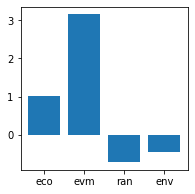

In [131]:
eco_MAE = AIC_df.set_index('Keywords')["MAE"][kw_eco].sum()
evm_MAE = AIC_df.set_index('Keywords')["MAE"][kw_evm].sum()
ran_MAE = AIC_df.set_index('Keywords')["MAE"][kw_ran].sum()
env_MAE = AIC_df.set_index('Keywords')["MAE"][kw_env].sum()
MAE_sums_df = pd.DataFrame([eco_MAE, evm_MAE, ran_MAE, env_MAE], index=['eco', 'evm', 'ran', 'env'], columns=['MAE sum'])

plt.figure(figsize=(3, 3))
plt.bar(MAE_sums_df['MAE sum'].reset_index()["index"], height=MAE_sums_df['MAE sum'])

In [161]:
import openpyxl
#AIC_df.to_excel('AIC_MAE.xlsx')